In [145]:
# Step 0. Import libraries and custom modules
# Basics ---------------------------------------------------
import logging
# Data -----------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Machine learning -----------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, 
                             ConfusionMatrixDisplay)
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import (OneHotEncoder,
                                   LabelEncoder,
                                   MinMaxScaler)

In [2]:
# Step 1. Load data and wrangle
# 1.1 Read from source and get basic info
url = ('https://gist.githubusercontent.com/teamtom/' + 
       '1af7b484954b2d4b7e981ea3e7a27f24/raw/' + 
       '114fb69dce56b4462a9c3a417e7402330616ad4f/' + 
       'titanic_full.csv')
df_raw = pd.read_csv(url)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  746 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [3]:
# 1.2 Get a sample
display(df_raw.sample(10, random_state=2024))

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1077,3,0,Franklin Mr. Charles Charles Fardon,male,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S,NaN,NaN,NaN
1177,3,0,Lindell Mrs. Edvard Bengtsson Elin Gerda Persson,female,30.0,1,0,349910,15.5500,NaN,S,A,NaN,NaN
1164,1,1,Beckwith Mrs. Richard Leonard Sallie Monypeny,female,47.0,1,1,11751,52.5542,D35,S,5,NaN,New York NY
370,3,1,Murphy Miss. Katherine Kate,female,NaN,1,0,367230,15.5000,NaN,Q,16,NaN,NaN
971,3,1,Hakkarainen Mrs. Pekka Pietari Elin Matilda Dolck,female,24.0,1,0,STON/O2. 3101279,15.8500,NaN,S,15,NaN,NaN
342,3,0,Danbom Mr. Ernst Gilbert,male,34.0,1,1,347080,14.4000,NaN,S,NaN,197.0,Stanton IA
459,1,0,Hipkins Mr. William Edward,male,55.0,0,0,680,50.0000,C39,S,NaN,NaN,London / Birmingham
365,3,0,Andersson Miss. Ellis Anna Maria,female,2.0,4,2,347082,31.2750,NaN,S,NaN,NaN,Sweden Winnipeg MN
69,3,0,Wiklund Mr. Karl Johan,male,21.0,1,0,3101266,6.4958,NaN,S,NaN,NaN,NaN
232,1,1,Harper Mrs. Henry Sleeper Myna Haxtun,female,49.0,1,0,PC 17572,76.7292,D33,C,3,NaN,New York NY


In [114]:
# 1.3 Make transformations
df_interim = (
    df_raw
    .drop(['ticket','boat','body','home.dest','cabin','name'], axis=1)
    .drop_duplicates()
    .assign(absent_age = df_raw['age'].apply(lambda x: 1 if pd.isna(x) else 0))
    .astype({'survived':'category', 
             'pclass': 'category', 
             'sex': 'category',
             'embarked':'category',
             'absent_age': 'category'})
)
df = df_interim.copy()

In [115]:
# Step 2. Perform EDA
# 2.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.20, 
                                     stratify=df['survived'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 540 to 744
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   pclass      891 non-null    category
 1   survived    891 non-null    category
 2   sex         891 non-null    category
 3   age         779 non-null    float64 
 4   sibsp       891 non-null    int64   
 5   parch       891 non-null    int64   
 6   fare        890 non-null    float64 
 7   embarked    889 non-null    category
 8   absent_age  891 non-null    category
dtypes: category(5), float64(2), int64(2)
memory usage: 39.8 KB


In [116]:
# 2.1 Get numerical and categorical summaries
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
age,779.0,29.933787,15.040307,0.17,20.25,28.0,39.0000,80.0000
sibsp,891.0,0.537598,0.992947,0.00,0.00,0.0,1.0000,8.0000
parch,891.0,0.436588,0.895160,0.00,0.00,0.0,1.0000,9.0000
fare,890.0,37.414035,58.028996,0.00,8.05,15.8,34.5844,512.3292


,count,unique,top,freq
pclass,891,3,3,458
survived,891,2,0,517
sex,891,2,male,555
embarked,889,3,S,622
absent_age,891,2,0,779


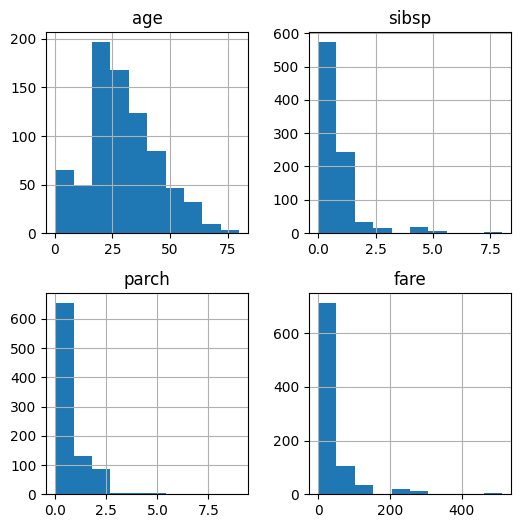

In [117]:
# 2.2 Perform univariate analysis on numerical variables
df_train.hist(figsize=(6,6))
plt.show()

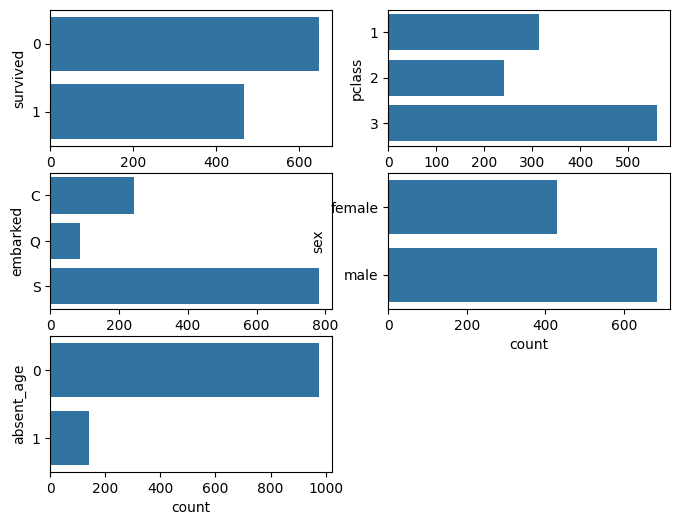

In [135]:
# 2.3 Perform univariate analysis for categorical variables
fig, ax = plt.subplots(3,2, figsize=(8,6))
sns.countplot(data=df, y='survived', ax=ax[0,0])
sns.countplot(data=df, y='pclass', ax=ax[0,1])
sns.countplot(data=df, y='embarked', ax=ax[1,0])
sns.countplot(data=df, y='sex', ax=ax[1,1])
sns.countplot(data=df, y='absent_age', ax=ax[2,0])
fig.delaxes(ax[2,1])
plt.show()

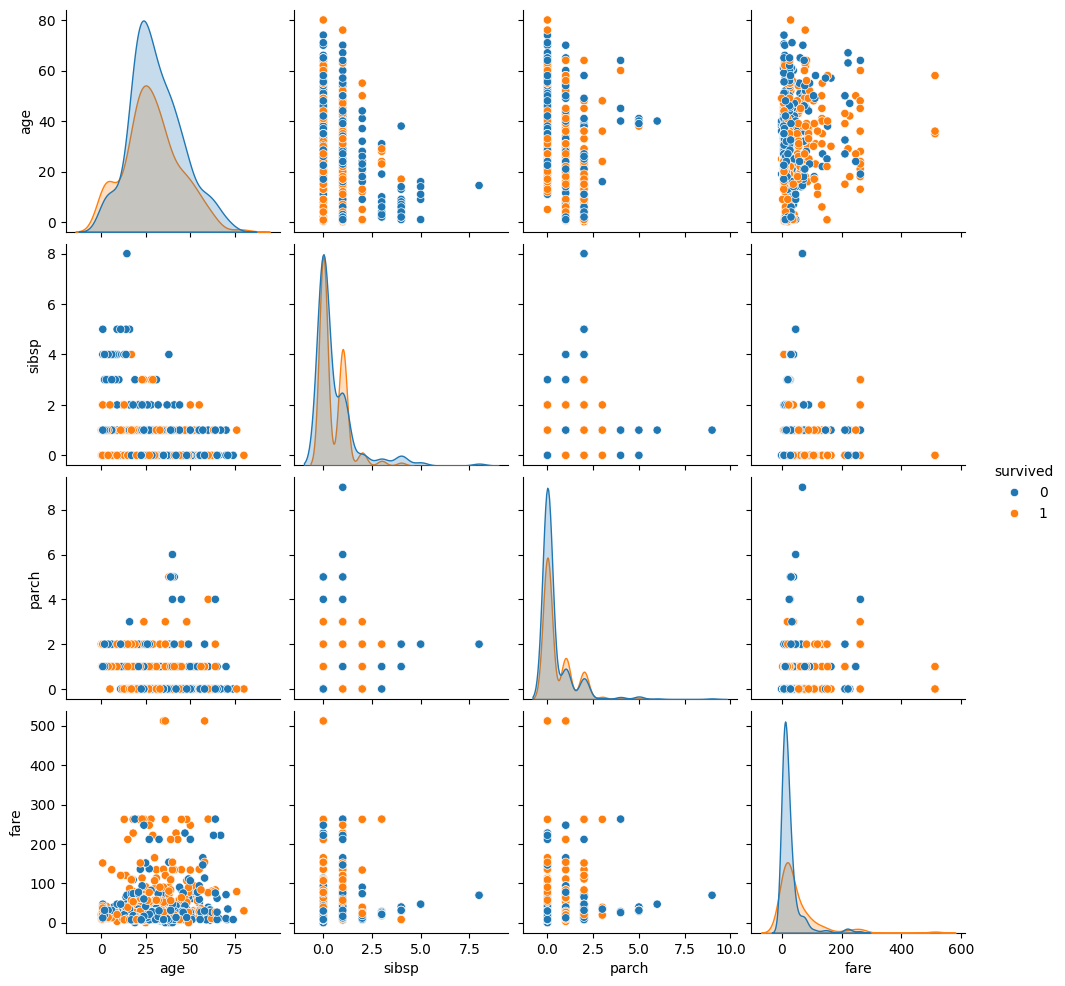

In [120]:
# 2.4 Perform bivariate analysis for numerical values, using target
sns.pairplot(data=df_train, hue='survived')
plt.show()

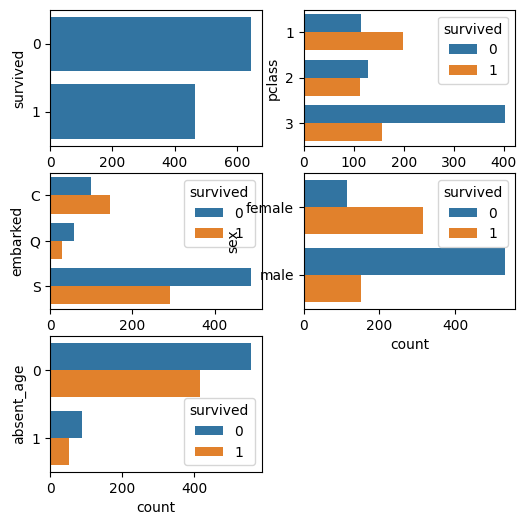

In [133]:
# 2.5 Perform bivariate analysis for categorical against target
fig, ax = plt.subplots(3,2, figsize=(6,6))
sns.countplot(data=df, y='survived', ax=ax[0,0])
sns.countplot(data=df, y='pclass', ax=ax[0,1], hue='survived')
sns.countplot(data=df, y='embarked', ax=ax[1,0], hue='survived')
sns.countplot(data=df, y='sex', ax=ax[1,1], hue='survived')
sns.countplot(data=df, y='absent_age', ax=ax[2,0], hue='survived')
fig.delaxes(ax[2,1])
plt.show()

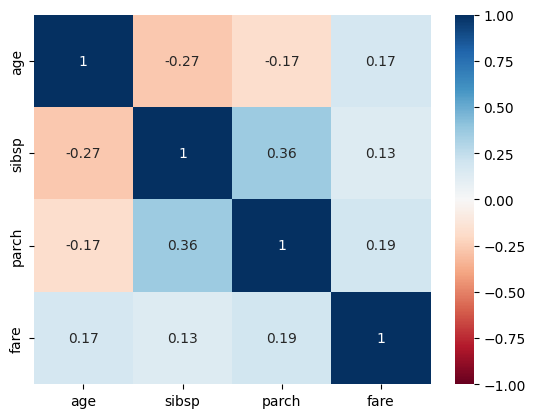

In [122]:
# 2.6 Perform correlation analysis
sns.heatmap(data=df_train.select_dtypes('number').corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

In [123]:
# Step 3. Machine learning
# 3.1 Create a pipeline
cat_cols = df_train.drop('survived', axis=1).select_dtypes('category').columns
num_cols = df_train.drop('survived', axis=1).select_dtypes('number').columns
cat_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
num_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('minmax', MinMaxScaler())
])
processor = ColumnTransformer(transformers=[
    ('cat', cat_proc, cat_cols),
    ('num', num_proc, num_cols)
])

In [124]:
encode_train = processor.fit_transform(df_train.drop('survived', axis=1))
df_train_tf = pd.DataFrame(encode_train, columns=processor.get_feature_names_out())
df_train_tf

,cat__pclass_1,cat__pclass_2,cat__pclass_3,cat__sex_female,cat__sex_male,cat__embarked_C,cat__embarked_Q,cat__embarked_S,cat__absent_age_0,cat__absent_age_1,num__age,num__sibsp,num__parch,num__fare
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.348616,0.000,0.000000,0.015412
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.636728,0.000,0.111111,0.119804
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.636728,0.125,0.000000,0.152164
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.574095,0.000,0.000000,0.154588
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.372840,0.000,0.000000,0.028221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.298509,0.125,0.000000,0.031425
887,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.411249,0.125,0.000000,0.175668
888,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.279719,0.000,0.000000,0.014102
889,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.693098,0.000,0.000000,0.015713


In [125]:
encode_test = processor.transform(df_test.drop('survived', axis=1))
df_test_tf = pd.DataFrame(encode_test, columns=processor.get_feature_names_out())
df_test_tf

,cat__pclass_1,cat__pclass_2,cat__pclass_3,cat__sex_female,cat__sex_male,cat__embarked_C,cat__embarked_Q,cat__embarked_S,cat__absent_age_0,cat__absent_age_1,num__age,num__sibsp,num__parch,num__fare
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.372840,0.000,0.0,0.025374
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.311036,0.125,0.0,0.034743
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.273456,0.000,0.0,0.040989
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.372840,0.000,0.0,0.016908
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.235876,0.000,0.0,0.058556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.486409,0.000,0.0,0.047138
219,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.398722,0.000,0.0,0.015176
220,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.398722,0.000,0.0,0.015412
221,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.298509,0.000,0.0,0.014631


In [126]:
clf = LogisticRegression()
clf.fit(df_train_tf, df_train['survived'])

LogisticRegression()

In [127]:
y_hat =clf.predict(df_test_tf)
y_hat

array([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0])

In [128]:
accuracy_score(y_hat, df_test['survived'])

0.7847533632286996

In [129]:
logreg = Pipeline(steps=[
    ('proc',processor),
    ('lreg', LogisticRegression(class_weight='balanced'))
]
)

In [130]:
logreg.fit(df_train.drop('survived', axis=1), df_train['survived'])


Pipeline(steps=[('proc',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['pclass', 'sex', 'embarked', 'absent_age'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('minmax',
                                                                   MinMaxScaler())]),
                                                  Index(['age', 'sibsp', 'parch', 'fare'], dtype='object'))])),
                ('lreg', LogisticRegression(class_weight='balanced'))])

Accuracy: 0.77


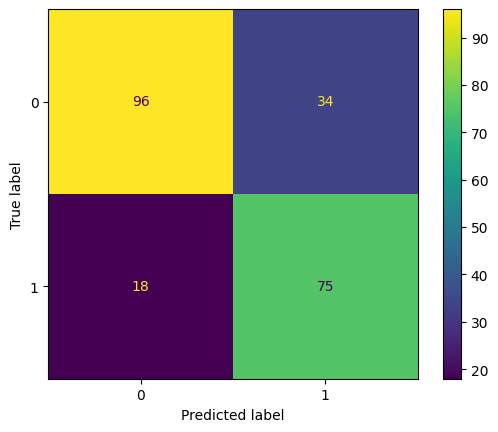

In [144]:
y_hat = logreg.predict(df_test.drop('survived', axis=1))
print(f'Accuracy: {accuracy_score(y_hat, df_test['survived']):.2f}')
ConfusionMatrixDisplay.from_predictions(df_test['survived'], y_hat)
plt.show()

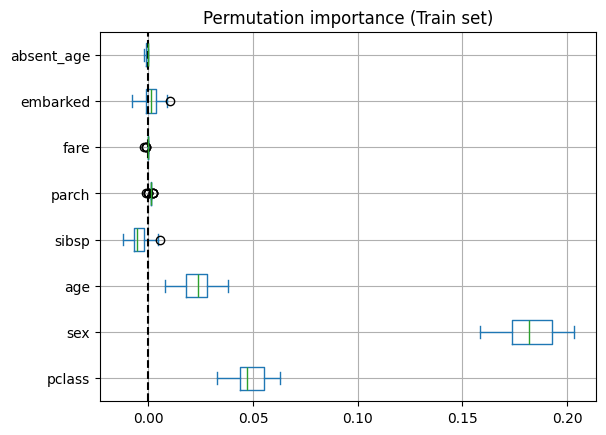

In [168]:
importance = permutation_importance(logreg, df_train.drop('survived', axis=1), df_train['survived'], n_repeats=25, random_state=2024)
importance_df = pd.DataFrame(importance.importances.T, columns=df_train.drop('survived', axis=1).columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0, color='k', linestyle='--')
ax.set_title('Permutation importance (Train set)')
ax.grid(True)
plt.show()